In [21]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [22]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [24]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [25]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [26]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [27]:
# Save references to each table
M = Base.classes.measurement
S = Base.classes.station

In [28]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [29]:
# Find the most recent date in the data set.
last_date = session.query(M.date).order_by(M.date.desc()).first().date
last_date

'2017-08-23'

In [30]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


Query Date:  2016-08-23 00:00:00


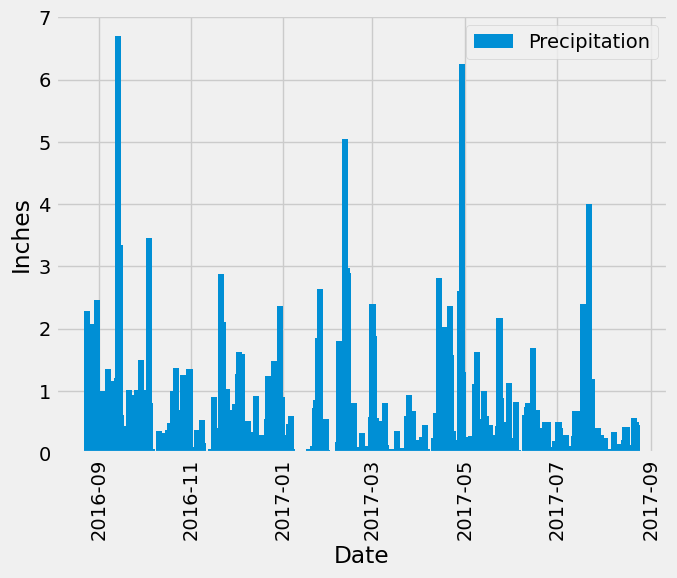

In [31]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
query_date = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Calculate the date one year from the last date in data set.
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(M.date, M.prcp).filter(M.date >= query_date).filter(M.prcp != 'None').order_by(M.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(prcp_data, columns = ['Date', 'Precipitation']) 
# df.astype({'Date': 'datetime64[ns]'})
df['Date'] = pd.to_datetime(df['Date'])
df.head()

# Sort the dataframe by date
df.sort_values('Date')

# # Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(7, 6))
plt.bar(df.Date, df.Precipitation, width = 4, label = 'Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(('Precipitation',), loc = 'best')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [32]:
# Use Pandas to calculate the summary statistics for the precipitation datad
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [33]:
# Design a query to calculate the total number of stations in the dataset
session.query(S.station).count()

9

In [41]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
best_stn = session.query(M.station, func.count(M.tobs)).group_by(M.station).order_by(func.count(M.tobs).desc()).all()
best_stn 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(M.tobs), func.max(M.tobs), func.avg(M.tobs)).filter(M.station == best_stn[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

In [37]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(M.station, M.tobs).filter(M.date >= query_date).filter(M.station == best_stn[0][0]).all()

In [38]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
tobs_df = pd.DataFrame(tobs_data, columns = ['Station', 'Tobs']) 
tobs_df.set_index('Station', inplace=True)
tobs_df.head()

,Tobs
Station,
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0


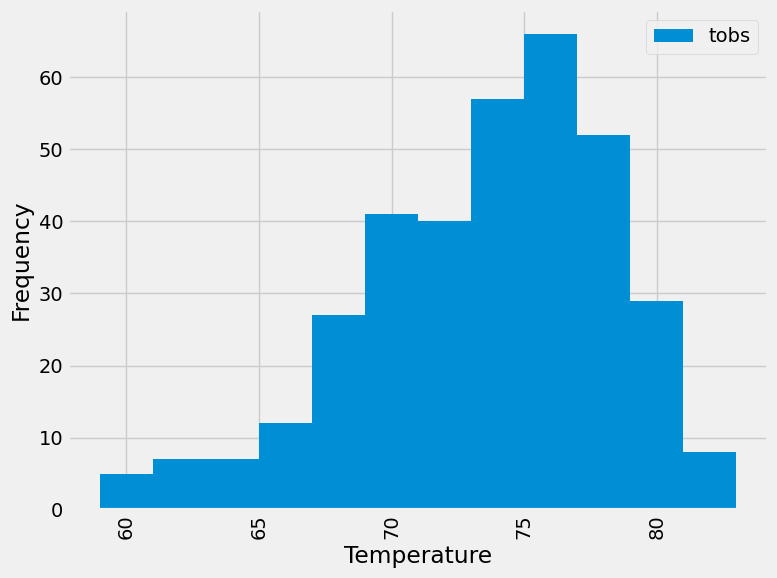

In [39]:
# Use Pandas Plotting with Matplotlib to plot the data
tobs_df.plot.hist( bins=12, figsize=(8,6))
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(('tobs',), loc = 'best')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Close Session

In [40]:
# Close Session
session.close()